In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
import json

In [2]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)

In [3]:
with open('config.json') as f:
    config = json.load(f)

data_path = config["data_path"]

ts = pd.read_csv(data_path)

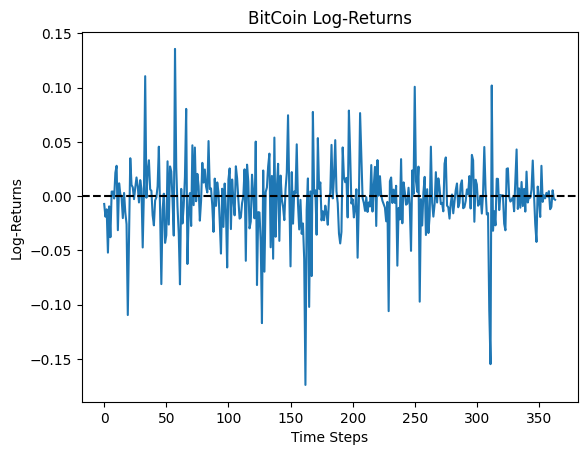

In [4]:
ts = ts["Close"].values
ts_log = np.log(ts)
returns = np.diff(ts_log)

plt.plot(returns)
plt.axhline(y=0, c="black", linestyle="--")
plt.title("BitCoin Log-Returns")
plt.xlabel('Time Steps')
plt.ylabel('Log-Returns')
plt.show()

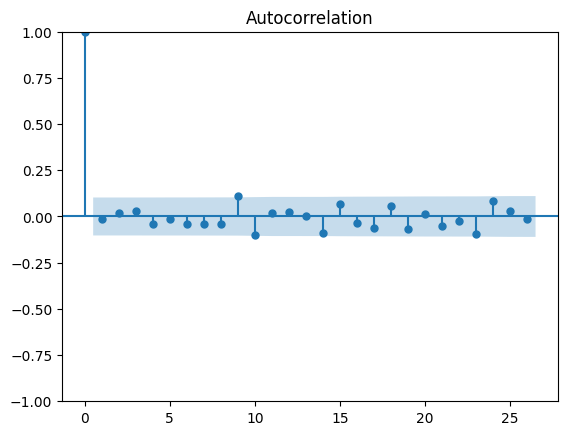

In [5]:
plot_acf(returns)
plt.show()

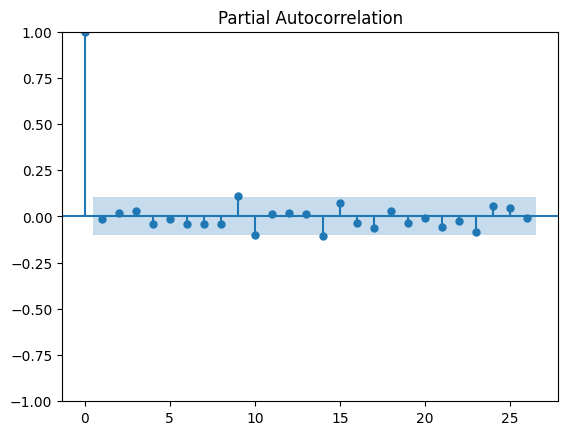

In [6]:
plot_pacf(returns)
plt.show()

In [7]:
unit_test = adfuller(returns)

#Print results
print('ADF Statistic: %f' % unit_test[0])
print('p-value: %f' % unit_test[1])
print('Critical Values:', unit_test[4])

if unit_test[1] <= 0.05:
    print(f'Reject the null hypothesis. The time-series is stationary.')
else: 
    print(f"Fail to reject the null hypothesis. The time-series is non-stationary")

ADF Statistic: -19.230854
p-value: 0.000000
Critical Values: {'1%': np.float64(-3.448493650810824), '5%': np.float64(-2.8695352280356556), '10%': np.float64(-2.5710293341377715)}
Reject the null hypothesis. The time-series is stationary.


In [8]:
# train-validation-test split for time series
train_size = int(len(returns) * 0.70)
train, rest = returns[:train_size], returns[train_size:]

validation_size = int(len(rest) * 0.50)
validation, test = rest[:validation_size], rest[validation_size:]

print(len(train))
print(len(validation))
print(len(test))

254
55
55


In [9]:
lowest_aic = float('inf')
best_p_aic = None
best_q_aic = None

lowest_bic = float('inf')
best_p_bic = None
best_q_bic = None

for p in range(1,10):
    for q in range(1,10):
        #create model
        model=ARIMA(train, order=(p,0,q))
        results = model.fit()

        #AIC and BIC of model
        aic = results.aic
        bic = results.bic
        print(f"AR({p}), MA({q}), AIC: {aic}, BIC: {bic}")

        #Update the best order based on the lowest AIC
        if aic < lowest_aic:
            lowest_aic = aic
            best_p_aic = p
            best_q_aic = q
        
        #Update the best order based on the lowest BIC
        if bic < lowest_bic:
            lowest_bic = bic
            best_p_bic = p
            best_q_bic = q

print(f"\nBest ARMA order based on AIC: ({best_p_aic},0,{best_q_aic}) \nBest ARMA order based on BIC: ({best_p_bic},0,{best_q_bic})")

AR(1), MA(1), AIC: -964.6401229613102, BIC: -950.4907858932361
AR(1), MA(2), AIC: -963.5034814993425, BIC: -945.8168101642498
AR(1), MA(3), AIC: -961.6967775340734, BIC: -940.4727719319621
AR(1), MA(4), AIC: -959.6993169205925, BIC: -934.9379770514628
AR(1), MA(5), AIC: -957.8142694977681, BIC: -929.5155953616198
AR(1), MA(6), AIC: -957.261268776163, BIC: -925.4252603729961
AR(1), MA(7), AIC: -955.241569185449, BIC: -919.8682265152636
AR(1), MA(8), AIC: -961.6106961120947, BIC: -922.7000191748908
AR(1), MA(9), AIC: -963.998668355307, BIC: -921.5506571510846
AR(2), MA(1), AIC: -962.6639309253856, BIC: -944.9772595902929
AR(2), MA(2), AIC: -963.943804097436, BIC: -942.7197984953248
AR(2), MA(3), AIC: -959.6945558629257, BIC: -934.9332159937959
AR(2), MA(4), AIC: -958.5683899036666, BIC: -930.2697157675183
AR(2), MA(5), AIC: -955.7028118734852, BIC: -923.8668034703184
AR(2), MA(6), AIC: -953.7513808308255, BIC: -918.3780381606401
AR(2), MA(7), AIC: -952.5046053083684, BIC: -913.5939283711

In [10]:
model = ARIMA(train, order=(3,0,8))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  254
Model:                 ARIMA(3, 0, 8)   Log Likelihood                 496.247
Date:                Mon, 09 Dec 2024   AIC                           -966.493
Time:                        18:39:31   BIC                           -920.508
Sample:                             0   HQIC                          -947.994
                                - 254                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0030      0.003     -1.148      0.251      -0.008       0.002
ar.L1         -1.4348      0.174     -8.233      0.000      -1.776      -1.093
ar.L2         -1.2414      0.194     -6.406      0.0

In [11]:
fitted = results.fittedvalues

In [12]:
mse = mean_squared_error(train, fitted)
rmse = sqrt(mse)
print(f"Train RMSE: {rmse}")

Train RMSE: 0.03425951368682621


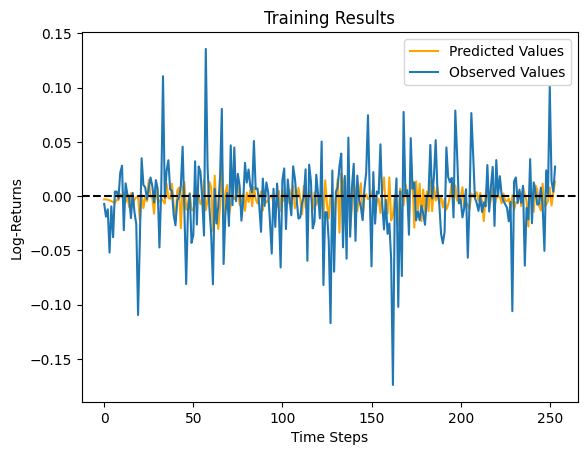

In [13]:
plt.plot(fitted, c='orange', label="Predicted Values")
plt.plot(train, label='Observed Values')
plt.axhline(y=0, c="black", linestyle="--")
plt.title("Training Results")
plt.xlabel('Time Steps')
plt.ylabel('Log-Returns')
plt.legend()
plt.show()

### Residual Diagnostics

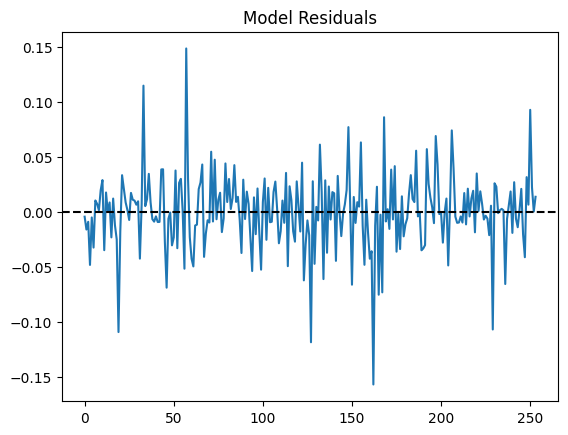

In [14]:
residuals = results.resid
plt.plot(residuals)
plt.axhline(y=0, c="black", linestyle="--")
plt.title("Model Residuals")
plt.show()

In [15]:
lagrange_t_stat, p_value, _, _ = acorr_breusch_godfrey(results, nlags=12)
print(f"Results from Breusch-Godfrey Test\nTest-Statistic: {lagrange_t_stat}\nP-Value: {p_value}")

if p_value <= 0.05:
    print(f"Reject the null hypothesis. Presence of serial correlation in the residuals is likely.")
else: 
    print(f"Fail to reject the null hypothesis. Evidence does not suggest serial correlation.")


Results from Breusch-Godfrey Test
Test-Statistic: 2.166072502039123
P-Value: 0.9991056776072931
Fail to reject the null hypothesis. Evidence does not suggest serial correlation.


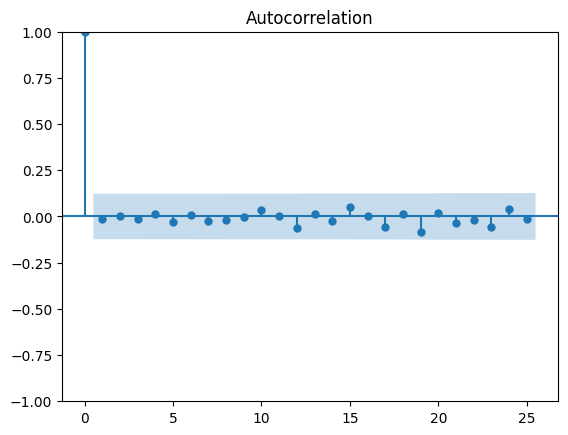

In [16]:
plot_acf(residuals)
plt.show()

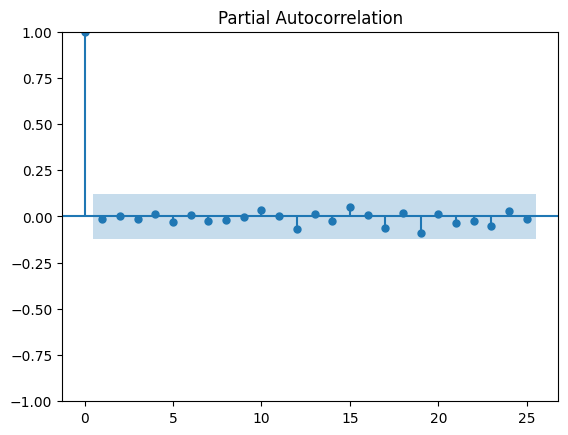

In [17]:
plot_pacf(residuals)
plt.show()

## Model Testing


In [18]:
def rolling_forecast():

    history = list(train)
    predictions = []

    for i in range(len(test+1)):
        model = ARIMA(history, order=(3,0,8))
        results = model.fit()
        
        #One-step-ahead forecast
        yhat = results.forecast()
        yhat = yhat[0]

        #Append history and predictions
        obs = test[i] #most recent observation
        history.append(obs)
        predictions.append(yhat)
        
        #Print predictions and observations at each step
        print(f'Step {i+1}: Observed: {obs}, Predicted: {yhat}')

    return predictions
            
yhat_test = rolling_forecast()

Step 1: Observed: -0.015587859772812962, Predicted: -0.003826729583811018
Step 2: Observed: -0.10542864722943435, Predicted: -0.008455702750641716
Step 3: Observed: -0.15488954815064382, Predicted: -0.010562380174008046
Step 4: Observed: 0.1020374089789744, Predicted: -0.019752907808970026
Step 5: Observed: -0.03191845327915388, Predicted: -0.01696831972173556
Step 6: Observed: -0.013898139634740403, Predicted: 0.009363975595258959
Step 7: Observed: -0.026896705438248958, Predicted: 0.0009562024496568965
Step 8: Observed: 0.01606473274734732, Predicted: 0.003728989920929295
Step 9: Observed: 0.01590431703026418, Predicted: 0.028937772785623036
Step 10: Observed: -0.012825680484175095, Predicted: -0.01315442849022513
Step 11: Observed: 0.0010839197204770556, Predicted: -0.020802153572866425
Step 12: Observed: 0.0006146275087619557, Predicted: -0.00916213803908002
Step 13: Observed: 0.0008242932834559014, Predicted: 0.035403664748568146
Step 14: Observed: -0.025436030670341836, Predicted

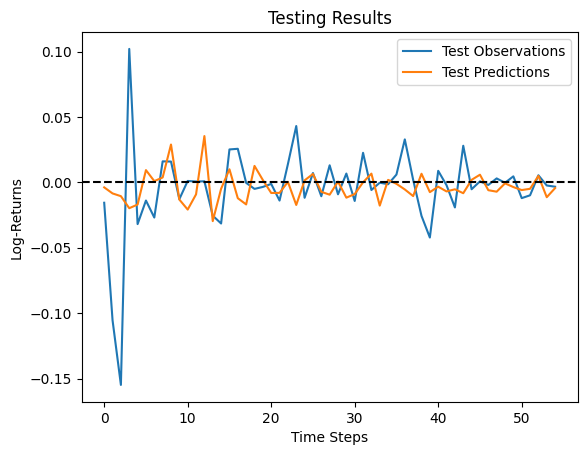

In [19]:
plt.plot(test, label='Test Observations')
plt.plot(yhat_test, label='Test Predictions')
plt.axhline(y=0, c="black", linestyle="--")
plt.title("Testing Results")
plt.xlabel('Time Steps')
plt.ylabel('Log-Returns')
plt.legend()
plt.show()

In [20]:
test_mse = mean_squared_error(test, yhat_test)
test_rmse = sqrt(test_mse)
print(f"Test RMSE: {test_rmse}")

Test RMSE: 0.03407982492944649


## Validation

In [ ]:
class model_selection:
    def __init__(self, training_set, validation_set, testing_set):
        #
        self.training_set = training_set
        self.validation_set = validation_set
        self.testing_set = testing_set

    def training(self):
        '''
        The purpose of this function is to select the appropriate model based on model performance on the training set. 
        
        Input: self
        Output: optimal ARMA order based on AIC and BIC, respectively
        '''
        
        train = self.training_set

        lowest_aic = float('inf')
        best_p_aic = None
        best_q_aic = None

        lowest_bic = float('inf')
        best_p_bic = None
        best_q_bic = None

        for p in range(1,6):
            for q in range(1,6):
                #create model
                model = ARIMA(train, order=(p,0,q))
                results = model.fit()

                #AIC and BIC of model
                aic = results.aic
                bic = results.bic
                print(f"AR({p}), MA({q}), AIC: {aic}, BIC: {bic}")

                #Update the best order based on the lowest AIC
                if aic < lowest_aic:
                    lowest_aic = aic
                    best_p_aic = p
                    best_q_aic = q
                
                #Update the best order based on the lowest BIC
                if bic < lowest_bic:
                    lowest_bic = bic
                    best_p_bic = p
                    best_q_bic = q

        return best_p_aic, best_q_aic, best_p_bic, best_q_bic
    
    def validiation(self):
        '''
        Selects the most optimal model parameters based on RMSE on the validation set. 

        Input: self
        Output: optimal p, optimal w, rmse, predictions
        '''
        
        validation_set = self.validation_set

        #These are the values to be returned by this function
        lowest_rmse = float('inf')
        best_p = None
        best_q = None

        history = list(self.validation_set)
        predictions = {}

        #Run through each possible p and q in our selected range
        for p in range(1,11):
            for q in range(1,11):
                #Create a list to hold the predictions of each ARMA order
                predictions[f'ARMA({p},0,{q}) Predictions'] = []

                #Run through each valdiation set observation
                for i in range(len(validation_set+1)):
                    model = ARIMA(history, order=(p,0,q))
                    results = model.fit()
                    
                    #One-step-ahead forecast
                    yhat = results.forecast()
                    yhat = yhat[0]

                    #Append history and predictions
                    obs = validation_set[i] #most recent observation
                    history.append(obs)
                    predictions[f'ARMA({p},0,{q}) Predictions'].append(yhat)

                #Calculate RMSE for the predictions 
                valid_mse = mean_squared_error(validation_set, predictions[f'ARMA({p},0,{q}) Predictions'])
                valid_rmse = sqrt(valid_mse)
                print(f"Validation RMSE for ARMA({p},0,{q}): {valid_rmse}")

                #Update optimal ARMA order based on RMSE
                if valid_rmse < lowest_rmse:
                    lowest_rmse = valid_rmse
                    best_p = p
                    best_q = q

                #Reset history
                history = list(self.validation_set) #reset history
                
                print(f"New best p and q: {best_p}, {best_q}")
                
        return best_p, best_q

In [24]:
selector = model_selection(train, validation, test)
best_p_valid, best_q_valid = selector.validiation()
print(f"\nMost Optimal ARMA Order based on validation set RMSE: ARMA({best_p_valid},0,{best_q_valid})")


Validation RMSE for ARMA(1,0,1): 0.0226555307977868
New best p and q: 1, 1
Validation RMSE for ARMA(1,0,2): 0.023493385952877907
New best p and q: 1, 2


KeyboardInterrupt: 